핸즈온 7장 <앙상블 학습과 랜덤 포레스트> p.245 - 257
__________________________________________________
# Chapter 7. 앙상블 학습과 랜덤 포레스트
- ### 7.1 투표 기반 분류기
- ### 7.2 배깅과 페이스팅
   - #### 7.2.1 사이킷런의 배깅과 페이스팅
   - #### 7.2.2 oob 평가

- ### 7.3 랜덤 패치과 랜덤 서브 스페이스
- ### 7.4 랜덤 포레스트
   - #### 7.4.1 엑스트라 트리
   - #### 7.4.2 특성 중요도
__________________________________________________

### 7.1 투표 기반 분류기
**분류기 종류**
- 직접 투표 분류기 : voting='hard'
- 간접 투표 분류기 : voting='soft', 분류기가 클래스의 확률의 예측할 수 있는 경우 ( = predict_proba( ) 메서드가 있는 경우)

**학습기 종류**
- 약한 학습기
- 강한 학습기

cf ) 예측기를 각기 다른 알고리즘으로 학습시킬시, 매우 다른 종류의 오차를 만들 가능성이 높아지고 앙상블 모델의 정확도도 높아짐.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# import package
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

# 5장에서 소개한 moons dataset 불러오기
X, y = make_moons(n_samples=100, noise=0.15)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
# 여러 분류기를 조합한 사이킷런의 투표 기반 분류기 생성 및 훈련
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators = [('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting = 'hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [ ]:
# 각 분류기의 테스트셋 정확도 확인
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.85
RandomForestClassifier 0.9
SVC 0.9
VotingClassifier 0.9


### 7.2 배깅과 페이스팅
**훈련세트에서 샘플링하는 방식에 따른 학습 방법**
- 배깅(bagging, bootstrap aggregating, bootstraping) : 중복을 허용하여 서브셋을 무작위로 구성
- 페이스팅(pasting) : 중복을 허용하지 않고 샘플링

**수집 함수는 전형적으로~**
- 분류일땐 통계적 최빈값 (직접 투표 분류기, 가장 많은 예측 결과)을
- 회귀일땐 평균을

계산함.

**앙상블의 예측은 개별 예측기의 예측보다~**
- 비슷한 편향에서 (= 훈련 세트의 오차 수가 거의 비슷하지만)
- 더 작은 분산을 (= 결정 경계는 덜 불규칙함.)
만듦.



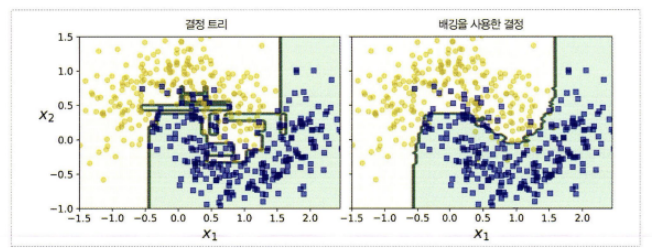

**배깅은 페이스팅보다 ~**
- 편향이 높음.
- 앙상블의 분산이 작음.
- 일반적으로 더 나은 모델을 만듦.

cf ) 예측이 동시에 다른 CPU 코어나 서버에서 병렬로 수행 가능해서 배깅, 페이스팅이 자주 사용됨.

####7.2.1 사이킷런의 배깅과 페이스팅


In [ ]:
# 결정 트리 분류기 500개로 구성된 앙상블을 무작위로 선택된 100개의 샘플로 배깅 훈련
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),
    n_estimators=500, max_samples=50, bootstrap=True, n_jobs=-1
)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

####7.2.2 oob 평가
**oob 샘플이란?** 선택되지 않은 훈련 샘플의 나머지 샘플을 의미

**oob 평가란?** 별도의 검증 세트를 사용하지 않고 oob 샘플을 사용하는 평가를 의미.

**oob 평가 관련 변수**
- oob_score_ : oob 평가 점수
- oob_decision_fuction : 각 훈련 샘플이 각 클래스에 속할 확률

cf) BaggingClassifier(oob_score=True) -> 자동으로 oob 평가를 수행함.

cf) 앙상블의 평가 시 각 예측기의 평가 점수를 평균함.


In [ ]:
# oob 평가 수행
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),
    n_estimators=500, bootstrap=True, n_jobs=-1,
    oob_score=True
)

bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.9375

In [ ]:
# 정확도 평가 수행
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9

In [ ]:
# oob 샘플에 대한 결정 함수의 값 확인
bag_clf.oob_decision_function_

array([[0.53488372, 0.46511628],
       [1.        , 0.        ],
       [0.46067416, 0.53932584],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.94413408, 0.05586592],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.87634409, 0.12365591],
       [0.50555556, 0.49444444],
       [0.9893617 , 0.0106383 ],
       [0.00549451, 0.99450549],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [0.05882353, 0.94117647],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [0.03723404, 0.96276596],
       [0.        , 1.        ],
       [0.9893617 , 0.0106383 ],
       [0.96756757, 0.03243243],
       [1.        , 0.        ],
       [0.05747126, 0.94252874],
       [0.57894737, 0.42105263],
       [1.        , 0.        ],
       [0.35323383, 0.64676617],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [0.

### 7.3 랜덤 패치과 랜덤 서브 스페이스
[정의]
- 랜덤 패치 방식(random patches method) : 훈련 특성과 샘플을 모두 샘플링하는 것
- 랜덤 서브스페이스 방식(random subspace method) : 훈련 샘플을 모두 사용하고 특성은 샘플링하는 것.
   - 훈련 샘플을 모두 사용 :  (bootstrap=False, max_samples=1.0)
   - 특성은 샘플링 :   
   (boostrap_features=True, max_features=0.7)

[특징]
- BaggingClassifier에서 특성 샘플링을 지원함.
- 특성 샘플링은 더 다양한 예측기를 만들며, 편향을 늘리고, 분산을 낮춤.
- 특성 샘플링은 특히 이미지와 같은 매우 고차원의 데이터셋을 다룰 때 유용함.

### 7.4 랜덤 포레스트
[정의]

- 랜덤 포레스트 : 배깅 또는 페이스팅 방법을 적용한 결정 트리의 앙상블

[특징]
- RandomForestClassifier = BaggingClassifier(DecisionTreeClassifier()) 로 표현 가능.
- RandomForestClassifier은 DecisionTreeClassifier의 매개변수 & BaggingClassifier의 앙상블 자체 제어 매개변수를 모두 가지고 있음.
- 랜덤포레스트는 무작위성을 더 주의함.
   - 트리를 다양화
   - 편향은 증가
   - 분산은 감소
- 랜덤 포레스트는 특성의 상대적 중요도를 측정하기 쉬움.

In [11]:
# 최대 16개의 리프 노드를 갖는 500개 트리로 이뤄진 랜덤 포레스트 분류기를 여러 CPU 코어에서 훈련
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

y_pred_rd = rnd_clf.predict(X_test)

In [12]:
# BaggingClassifier을 사용해 RandomForestClassifier와 유사하게 생성
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features='auto', max_leaf_nodes=16),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1
)

####7.4.1 엑스트라 트리
[정의]
- 엑스트라 트리(extra-trees, 익스트림 랜덤 트리) : 극단적으로 무작위한 트리의 랜덤 포레스트
   - 무작위한 트리의 랜덤 포레스트 : 트리를 만들 때 후보 특성을 사용해 무작위로 분할한 후 그 중에서 최상의 분할을 선택하는 방식으로 이루어진 랜덤 포레스트

[특성]
- ExtraTreesClassifier
- 엑스트라 트리가 일반 랜덤 포레스트보다 훨씬 빠름.
   - 노드에서 특성마다 최적의 임곗값을 찾는 것이 트리 알고리즘에서 가장 시간이 많이 소요되는 작업이기 때문임.



####7.4.2 특성 중요도

- 사이킷런은 어떤 특성을 사용한 노드가 모든 트리에 걸쳐서 평균적으로 불순도를 얼마나 감소시키는지를 기준으로 특성의 중요도를 측정함.
   - 각 노드의 가중치 평균을 계산한 값 (가중치 = 연관된 훈련 샘플 수)
- 사이킷런은 자동으로 특성 중요도를 계산하고 결괏값을 정규화함.
- feature_importances_


In [15]:
# 각 특성의 상대적 중요도 출력
from sklearn.datasets import load_iris
iris = load_iris()

rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris['data'], iris['target'])
for name, score in zip(iris['feature_names'], rnd_clf.feature_importances_):
  print(name, score*100, '%')

sepal length (cm) 9.5379371246771 %
sepal width (cm) 2.2431170499703215 %
petal length (cm) 45.84698448692838 %
petal width (cm) 42.37196133842421 %
